In [13]:
import numpy as np
from rul_pm.dataset.CMAPSS import CMAPSSDataset, sensor_indices
from rul_pm.models.keras.models.XCM import XCM
from sklearn.model_selection import train_test_split
from rul_pm.iterators.batcher import Batcher

from rul_pm.transformation.features.selection import (
    ByNameFeatureSelector)
from rul_pm.transformation.features.scalers import PandasMinMaxScaler
from rul_pm.transformation.features.imputers import PandasMeanImputer
from rul_pm.transformation.target import PicewiseRUL
from rul_pm.transformation.transformers import Transformer
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set()

## Loading data

In [14]:
dataset = CMAPSSDataset()
train_dataset, test_dataset = train_test_split(dataset)

## Training model

### Defining the transformer

In [15]:
features = [train_dataset[0].columns[i] for i in sensor_indices]

functional_pipe = ByNameFeatureSelector(features)
functional_pipe = PandasMinMaxScaler((-1,1), robust=False)(functional_pipe)
functional_pipe = PandasMeanImputer()(functional_pipe)

target_pipe = ByNameFeatureSelector(['RUL'])
target_pipe = PicewiseRUL(125)(target_pipe)

transformer = Transformer(
    transformerX=functional_pipe.build(),
    transformerY=target_pipe.build())

### Fitting the transformer

In [16]:
transformer.fit(train_dataset)

### Training the model

In [5]:
step = 3
batch_size = 16
window = 64
train_batcher = Batcher.new(train_dataset,  
                            window, 
                            batch_size, 
                            transformer, 
                            step, 
                            shuffle='all',
                            cache_size=500)
val_batcher = Batcher.new(test_dataset,  
                            window, 
                            batch_size, 
                            transformer, 
                            step, 
                            shuffle=False,
                            cache_size=500,
                            restart_at_end=False)

In [6]:
model = XCM(n_filters=64, learning_rate=0.001)
history = model.fit(train_batcher, val_batcher)

/home/luciano/venvs/rul_pm_38/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 14)]     0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 64, 14, 64)   4416        input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 64, 64)       6592        input_5[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 1)            11395       model[0][0]                      
                                                                 model_1[0][0]              

KeyboardInterrupt: 

### Obtain the explanation

In [7]:
from tqdm.auto import tqdm
features_m = []
time_m = []
for X,s,w in tqdm(val_batcher.iterator):
    a, b = model.explain(X, 0)
    features_m.append(np.mean(a,axis=0))
    time_m.append(b)





  0%|          | 0/9425 [00:00<?, ?it/s]

KeyboardInterrupt: 

AxisError: axis 1 is out of bounds for array of dimension 1

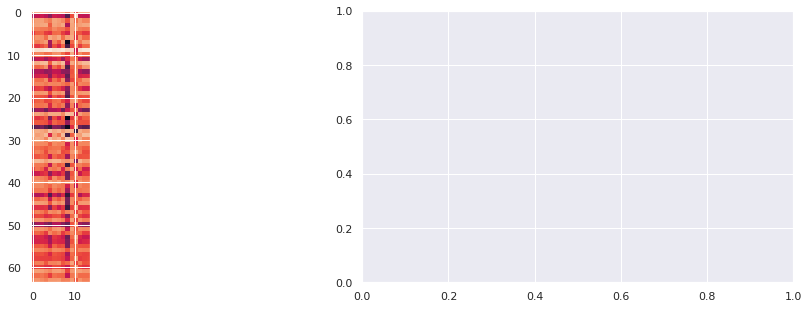

In [24]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
ax[0].imshow(a)
ax[1].imshow(np.repeat(b, 5, axis=0))

Text(0.5, 0, 'Importance')

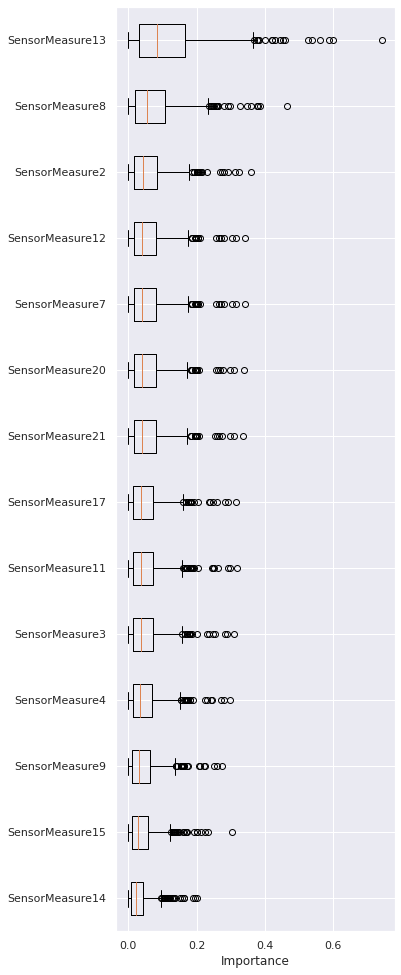

In [17]:
features_m_joined = np.vstack(features_m)
time_m_joined = np.vstack(time_m)


fig, ax = plt.subplots(figsize=(5, 17))
indices = np.argsort(np.mean(np.abs(features_m_joined), axis=0))
im = ax.boxplot(np.abs(features_m_joined[:, indices]),
               labels=[features[i] for i in indices],
              vert=False
               )
ax.set_xlabel('Importance')